In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk # sudo pip3 install lightkurve

import kepler_io
## These are the import statments in kepler_io
# import os.path
# from os import path
# from astropy.io import fits
# import numpy as np
## If you don't have astopy, sudo pip3 install astropy

from lightkurve import *

In [12]:
"""
You need to store the 87.23 GB kepler directory outside of github's reach. You don't want to commit that. 

Here's a file system that would work with the existing code.
/SIR/kepler
/SIR/PlanetHuntersRepo/dr24_tce
/SIR/PlanetHuntersRepo/dataCleansing.ipynb
/SIR/PlanetHuntersRepo/kepler_io.py

"""


KEPLER_DATA_DIR = "../kepler/"
KEPLER_ID = 11442793  #   # Kepler-90. 1160891

# Read the light curve.
file_names = kepler_io.kepler_filenames(KEPLER_DATA_DIR, KEPLER_ID)
assert file_names, "Failed to find .fits files in {}".format(KEPLER_DATA_DIR)

all_time, all_flux = kepler_io.read_kepler_light_curve(file_names)
print("Read light curve with {} segments".format(len(all_time)))

Read light curve with 14 segments


In [3]:
TCE_DIR = "dr24_tce.csv"
tce_df = pd.read_csv(TCE_DIR, skiprows=27)
# tce_df.iloc[0]
tce_df.head()

,kepid,tce_plnt_num,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_impact,tce_impact_err,tce_duration,tce_duration_err,...,tce_prad,tce_prad_err,tce_eqt,tce_eqt_err,tce_steff,tce_steff_err,tce_slogg,tce_slogg_err,tce_sradius,tce_sradius_err
0,1162345,2,0.831850,0.000067,132.227,0.035197,0.92600,1.471,2.392,21.0000,...,0.5099,0.7944,2760.0,637.0,6510.0,207.0,4.07,0.26,1.728,0.791
1,1292087,2,1.095240,0.000010,132.133,0.002685,0.25630,13.310,2.122,0.4755,...,0.8916,0.6361,2310.0,661.0,6328.0,207.0,4.15,0.29,1.502,0.852
2,1293031,2,0.719273,0.000014,132.227,0.002786,0.70000,1.103,1.521,0.3183,...,1.4550,0.4296,3330.0,703.0,6363.0,214.0,3.80,0.35,2.489,1.036
3,1162345,3,0.831833,0.000009,131.919,0.002209,0.09536,51.770,2.181,1.2110,...,0.9062,0.8488,2760.0,637.0,6510.0,207.0,4.07,0.26,1.728,0.791
4,1164109,1,622.408000,0.008547,162.256,0.009840,0.00319,2193.000,12.010,1.8430,...,2.1140,2.5990,302.0,75.0,6609.0,200.0,4.11,0.28,1.654,0.816


In [4]:
# Feed lightcurve into lightkurve engine
filename = file_names[0]
tpf = lk.lightcurvefile.KeplerLightCurveFile(filename) # import the given filename into lightkurve
sap_lc = tpf.SAP_FLUX
pdcsap_lc = tpf.PDCSAP_FLUX

The following cell shows the difference between raw SAP_FLUX and cleansing with KeplerCBVCorrector.
The math is briefly described in the docs: https://docs.lightkurve.org/api/lightkurve.correctors.KeplerCBVCorrector.html#lightkurve.correctors.KeplerCBVCorrector

The result of using CBV is extremely similar to (yet not identical to) PDCSAP_FLUX, provided by NASA with the downloaded lightcurve files. However, NASA's method is "subject to change," meaning that their documentation could be updated to describe a different method than what was used when the data was previously downloaded. 

Additionally, CBV is something that we can control when generating simulated transits.

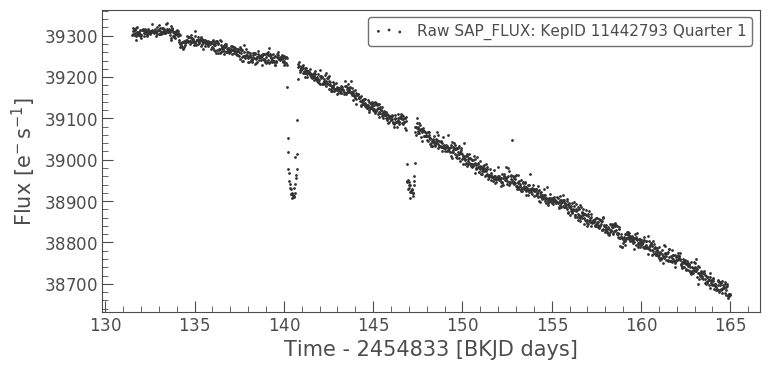

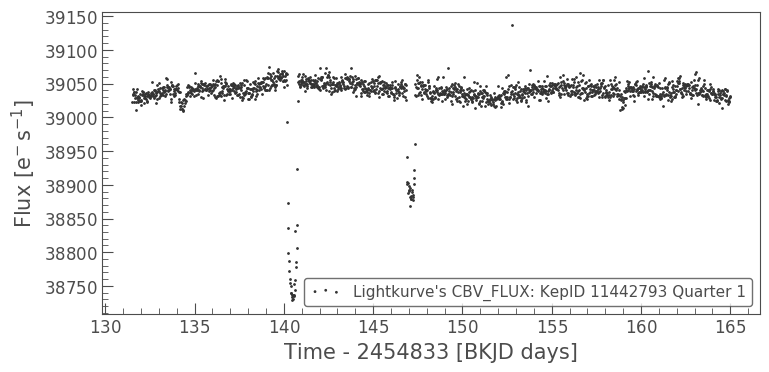

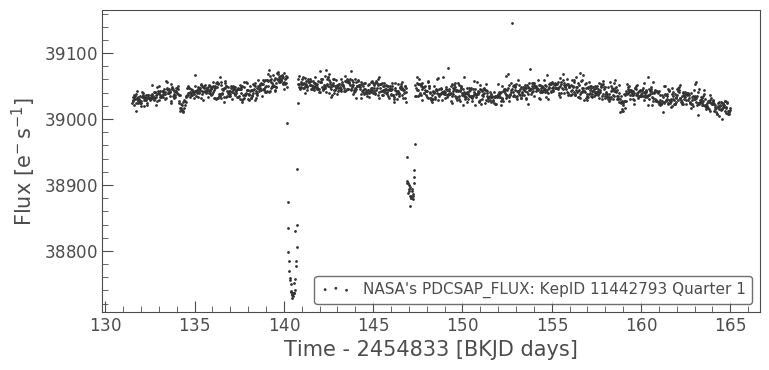

In [5]:
cbv_lc = KeplerCBVCorrector(sap_lc).correct()
sap_lc.scatter(label="Raw SAP_FLUX: KepID {} Quarter {}".format(sap_lc.targetid, sap_lc.quarter))
cbv_lc.scatter(label="Lightkurve's CBV_FLUX: KepID {} Quarter {}".format(cbv_lc.targetid, cbv_lc.quarter))
pdcsap_lc.scatter(label="NASA's PDCSAP_FLUX: KepID {} Quarter {}".format(pdcsap_lc.targetid, pdcsap_lc.quarter))

As CBV_FLUX and PDCSAP_FLUX can appear to be identical when plotted on two separate graphs, the following plot shows the two on the same graph.

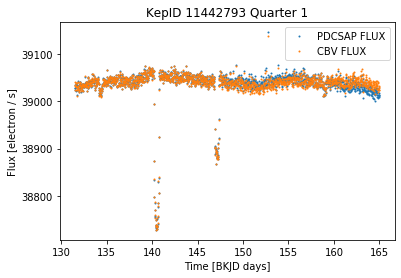

In [6]:
plt.plot(pdcsap_lc.time, pdcsap_lc.flux, 'o', markersize=1, label='PDCSAP FLUX')
plt.plot(cbv_lc.time, cbv_lc.flux, 'o', markersize=1, label='CBV FLUX')
plt.title("KepID {} Quarter {}".format(pdcsap_lc.targetid, pdcsap_lc.quarter))
plt.ylabel("Flux [{}]".format(cbv_lc.flux_unit))
plt.xlabel("Time [{} days]".format(cbv_lc.time_format.upper()))
plt.legend()

The following method flattens the cbv lightcurve using a Savitzky-Golay filter.


Docs: https://docs.lightkurve.org/api/lightkurve.lightcurve.KeplerLightCurve.html#lightkurve.lightcurve.KeplerLightCurve.flatten


Savitzky-Golay filter https://en.wikipedia.org/wiki/Savitzky–Golay_filter

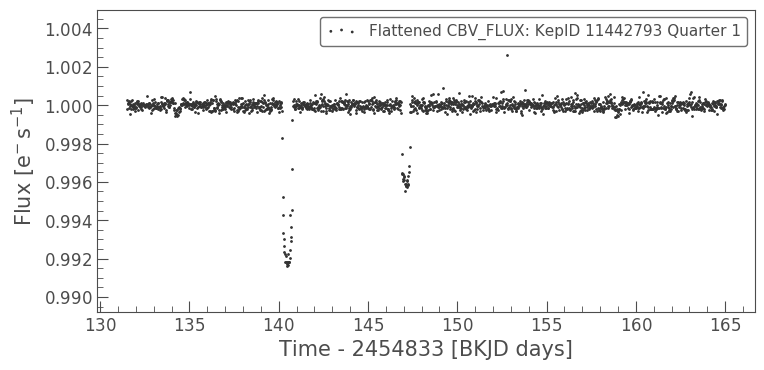

In [7]:
flat_lc = cbv_lc.flatten()
flat_lc.scatter(label="Flattened CBV_FLUX: KepID {} Quarter {}".format(flat_lc.targetid, flat_lc.quarter))

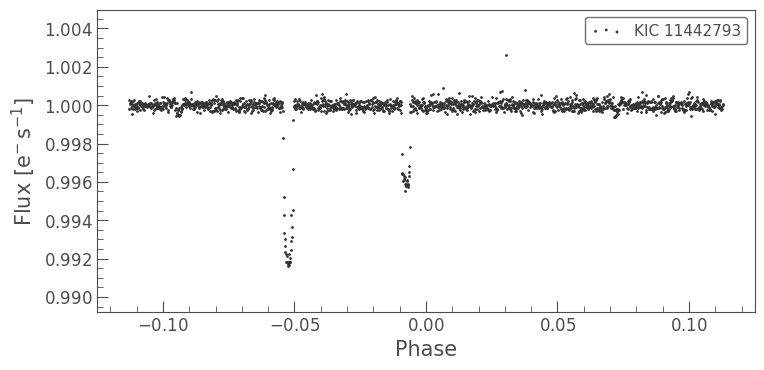

In [8]:
flat_lc.fold(flat_lc.time[int(len(flat_lc)/2.0)]).scatter()

In [9]:
kid = flat_lc.targetid
tce_df[tce_df.kepid == kid]

,kepid,tce_plnt_num,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_impact,tce_impact_err,tce_duration,tce_duration_err,...,tce_prad,tce_prad_err,tce_eqt,tce_eqt_err,tce_steff,tce_steff_err,tce_slogg,tce_slogg_err,tce_sradius,tce_sradius_err
17694,11442793,1,331.603,0.000284,140.48,0.000753,0.1126,0.3101,14.49,0.08944,...,10.91,0.09187,294.0,28.3,5970.0,119.0,4.32,0.13,1.2,0.226


140.48 0.0007531069999999999


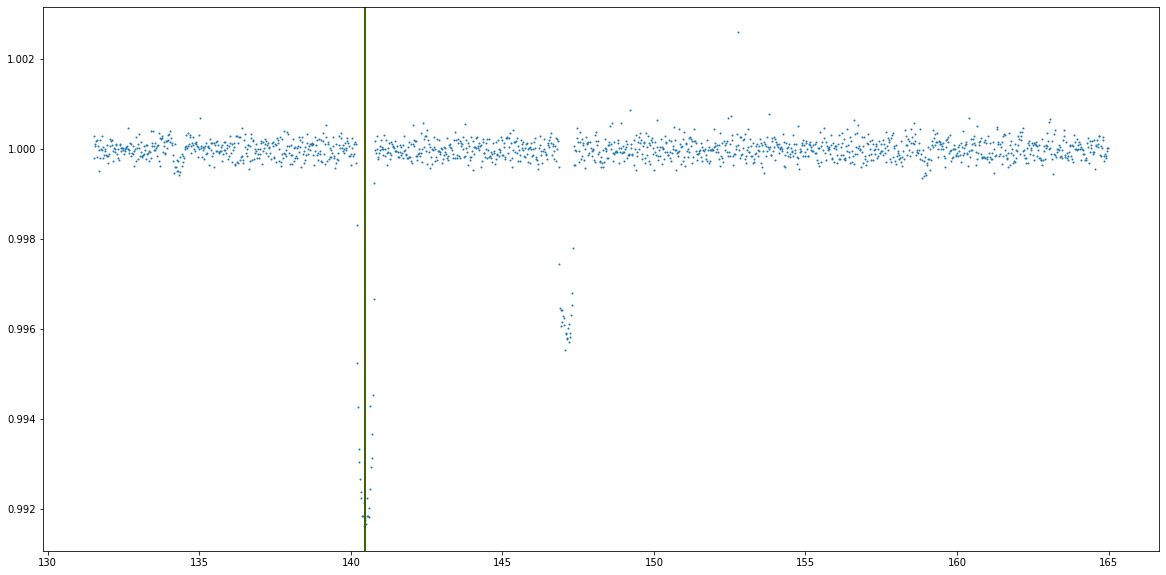

In [10]:

plt.figure(figsize=(20,10))
plt.plot(flat_lc.time, flat_lc.flux, 'o', markersize=1)
target_rows = tce_df[tce_df.kepid == kid]
for i in range(len(target_rows)):
    
    time, error = target_rows['tce_time0bk'].iloc[i], target_rows['tce_time0bk_err'].iloc[i]
    print(time, error)
    
    plt.axvline(x=time+error, c='r')
    plt.axvline(x=time-error, c='r')
    plt.axvline(x=time, c='g')
    
    

In [11]:
ids = tce_df.kepid
for i in ids[:10]:
    matches = len([x for x in ids if x == i])
    if matches > 1:
        print(matches, i)

3 1162345
2 1292087
2 1293031
3 1162345
2 1026032
2 1026032
